<a href="https://colab.research.google.com/github/gfidelisp/Jet_Impingement/blob/main/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Montando os arquivos no Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Localizando a pasta com os arquivos

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Jet_Impingement')

## Importando os packages

In [ ]:
# Instalação do detecto
!pip install detecto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importandos os packages que serão utilizados

In [ ]:
import cv2
import shutil
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.patches as patches

import torch
from torchvision import transforms

from detecto import utils
from detecto import core
from detecto import visualize
from detecto.core import Model
from detecto.utils import reverse_normalize, normalize_transform, _is_iterable

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, RandomRotation
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import unit_norm

# Detecção e Lozalização da Zona de Teste

Leitura dos conjuntos de dados de treino e de teste

In [ ]:
utils.xml_to_csv('Data/Input_Data/Annotations/train_labels', 'Data/Input_Data/Annotations/train.csv')
utils.xml_to_csv('Data/Input_Data/Annotations/val_labels', 'Data/Input_Data/Annotations/val.csv')

,filename,width,height,class,xmin,ymin,xmax,ymax,image_id
0,0a066495-M8_125_6.png,640,480,Zona de teste,200,237,430,279,0
1,5fe459e4-M8_225_1.png,640,480,Zona de teste,193,232,435,281,1
2,5d3d6917-M8_225_4.png,640,480,Zona de teste,195,235,427,290,2
3,2f6f1055-M6_75_0.png,640,480,Zona de teste,269,280,483,325,3
4,4ee25673-M6_50_4.png,640,480,Zona de teste,261,276,484,327,4
5,0b9e92db-M8_50_6.png,640,480,Zona de teste,199,230,424,281,5
6,1eec4e93-M6_50_5.png,640,480,Zona de teste,258,279,480,326,6
7,2dafdf9c-M1_125_4.png,640,480,Zona de teste,198,177,414,224,7
8,06bc84db-M1_175_0.png,640,480,Zona de teste,198,178,409,230,8
9,4ffa7006-M6_150_1_6.png,640,480,Zona de teste,258,276,487,328,9


Observando uma imagem 

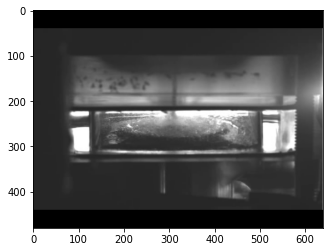

In [ ]:
image = img.imread('Data/Input_Data/Annotations/images/5fe459e4-M8_225_1.png')
plt.imshow(image)
plt.show()

Transformando a imagem para que possa ser tratada

In [ ]:
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(800),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    utils.normalize_transform(),
])

Definição e transformação do Dataset

In [ ]:
dataset = core.Dataset('Data/Input_Data/Annotations/train.csv', 'Data/Input_Data/Annotations/images/', transform=transform_img)

Visualização da imagem anotada

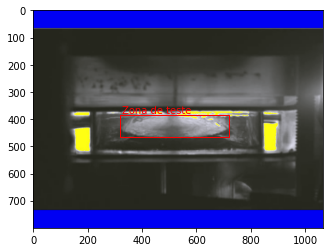

In [ ]:
image, information = dataset[50] 
visualize.show_labeled_image(image, information['boxes'], information['labels'])

## Treinamento do classificador

Carregando o Dataset

In [ ]:
dataloader = core.DataLoader(dataset)

Conjunto de validação

In [ ]:
validation_data = core.Dataset('Data/Input_Data/Annotations/val.csv', 'Data/Input_Data/Annotations/images/')

Definição das categorias

In [ ]:
categories = ['Zona de teste']
classifier = core.Model(categories)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Treinamento do classificador

In [ ]:
# history = classifier.fit(dataloader, validation_data, epochs = 30, verbose = True)

Salvando o modelo

In [ ]:
#classifier.save('Data/Output_Data/Annotations/Models/Zona_de_Teste.pth')

Carregando o Modelo

In [ ]:
classifier = Model.load('Data/Output_Data/Annotations//Models/Zona_de_Teste.pth', ['Zona de Teste'])

Função para a aplicação do classificador treinado em um arquivo de vídeo.


A função "detect_video" disponível no package "detecto" apresentava alguns erros, por isso implementamos aqui a versão disponível no GitHub do Package e corrigimos os error. 

In [ ]:
def detect_video_1(model, input_file, output_file, fps=30, score_filter=0.6):
    """Takes in a video and produces an output video with object detection
    run on it (i.e. displays boxes around detected objects in real-time).
    Output videos should have the .avi file extension. Note: some apps,
    such as macOS's QuickTime Player, have difficulty viewing these
    output videos. It's recommended that you download and use
    `VLC <https://www.videolan.org/vlc/index.html>`_ if this occurs.
    :param model: The trained model with which to run object detection.
    :type model: detecto.core.Model
    :param input_file: The path to the input video.
    :type input_file: str
    :param output_file: The name of the output file. Should have a .avi
        file extension.
    :type output_file: str
    :param fps: (Optional) Frames per second of the output video.
        Defaults to 30.
    :type fps: int
    :param score_filter: (Optional) Minimum score required to show a
        prediction. Defaults to 0.6.
    :type score_filter: float
    **Example**::
        >>> from detecto.core import Model
        >>> from detecto.visualize import detect_video
        >>> model = Model.load('model_weights.pth', ['tick', 'gate'])
        >>> detect_video(model, 'input_vid.mp4', 'output_vid.avi', score_filter=0.7)
    """

    # Read in the video
    video = cv2.VideoCapture(input_file)

    # Video frame dimensions
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Scale down frames when passing into model for faster speeds
    scaled_size = 800
    scale_down_factor = min(frame_height, frame_width) / scaled_size

    # The VideoWriter with which we'll write our video with the boxes and labels
    # Parameters: filename, fourcc, fps, frame_size
    out = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'DIVX'), fps, (frame_width, frame_height))

    # Transform to apply on individual frames of the video
    transform_frame = transforms.Compose([  # TODO Issue #16
        transforms.ToPILImage(),
        transforms.Resize(scaled_size),
        transforms.ToTensor(),
        normalize_transform(),
    ])

    # Loop through every frame of the video
    while True:
        ret, frame = video.read()
        # Stop the loop when we're done with the video
        if not ret:
            break

        # The transformed frame is what we'll feed into our model
        # transformed_frame = transform_frame(frame)
        transformed_frame = frame  # TODO: Issue #16
        predictions = model.predict(transformed_frame)

        # Add the top prediction of each class to the frame
        for label, box, score in zip(*predictions):
            if score < score_filter:
                continue

            # Since the predictions are for scaled down frames,
            # we need to increase the box dimensions
            # box *= scale_down_factor  # TODO Issue #16

            # Create the box around each object detected
            # Parameters: frame, (start_x, start_y), (end_x, end_y), (r, g, b), thickness

            cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 3)

            # Write the label and score for the boxes
            # Parameters: frame, text, (start_x, start_y), font, font scale, (r, g, b), thickness
            cv2.putText(frame, '{}: {}'.format(label, round(score.item(), 2)), (int(box[0]), int(box[1]) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 3)

        # Write this frame to our video file
        out.write(frame)

        # If the 'q' key is pressed, break from the loop
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

    # When finished, release the video capture and writer objects
    video.release()
    out.release()

    # Close all the frames
    cv2.destroyAllWindows()

Aplicando o classificador treinados nos arquivos de vídeos

In [ ]:
# detect_video_1(classifier, 'Data/Input_Data/Annotations/Videos/M1_25.mp4','Data/Output_Data/Annotations/Videos/M1_25_box.avi')

In [ ]:
# detect_video_1(classifier, 'Data/Input_Data/Annotations/Videos/M6_225.mp4','Data/Output_Data/Annotations/Videos/M6_225_box.avi')

In [ ]:
# detect_video_1(classifier, 'Data/Input_Data/Annotations/Videos/M8_100.mp4','Data/Output_Data/Annotations/Videos/M8_100_box.avi')

# Capturando os Frames

Lista com os videos que serão avaliados

In [ ]:
Video_list = os.listdir('Data/Input_Data/Videos')

Função para a captura dos frames

Está comentada pois não precisa ser rodada

for i in Video_list:

    # Carregando o Vídeo 
    Vid = cv2.VideoCapture('Data/Input_Data/Videos/'+ i)

    # Estabelecendo o intervalo de captura dos frames
    frameRate = 1*Vid.get(5)

    # Frame atual
    currentframe = 0
    
    while(True):

        frameId = Vid.get(1)

        # Carregando o frame do vídeo
        ret,frame = Vid.read()
    
        if ret:
            if (frameId % math.floor(frameRate) == 0):
                # Criação das imagens
                name = 'Data/Output_Data/Frames/' + str(i[:-4]) + '_' + str(currentframe) + '.png'
                print ('Creating...' + name)
        
                # Salvando as imagens
                cv2.imwrite(name, frame)
        
                # Contador
                currentframe += 1
        else:
            break
            
cv2.destroyAllWindows()

# Cortando os frames na Zona de Teste

Lista com os frames sendo avaliados

In [ ]:
frames_list = os.listdir('Data/Output_Data/Frames')

Função para o corte dos frames

Comentada pois não precisa ser rodada

for i in frames_list:
  im = cv2.imread("Data/Output_Data/Frames/" + i)

  #### Determinando as coordenadas da zona de teste
  predictions = classifier.predict(im)
  labels, box, scores = predictions

  left = int(box[0][0])
  right = int(box[0][2])
  top = int(box[0][3])
  bottom = int(box[0][1]) + 10

  ##### Salvando a imagem recortada
  im_crop = im[bottom:top, left:right]
  name = 'Data/Output_Data/Frames_Cropped/' + str(i[:-4])+ '.png'
  cv2.imwrite(name, im_crop)

  #### Contador
  print(i)

# Separação dos conjunto de treino e teste

In [ ]:
data_dir = "Data/Output_Data/Sets/"

#create training dir
training_dir = os.path.join(data_dir,"training")
if not os.path.isdir(training_dir):
  os.mkdir(training_dir)

#create ok dir in training
ok_training_dir = os.path.join(training_dir,"Ok")
if not os.path.isdir(ok_training_dir):
  os.mkdir(ok_training_dir)

#create crit dir in training
crit_training_dir = os.path.join(training_dir,"Crit")
if not os.path.isdir(crit_training_dir):
  os.mkdir(crit_training_dir)

#create validation dir
validation_dir = os.path.join(data_dir,"validation")
if not os.path.isdir(validation_dir):
  os.mkdir(validation_dir)

#create ok in validation
ok_validation_dir = os.path.join(validation_dir,"Ok")
if not os.path.isdir(ok_validation_dir):
  os.mkdir(ok_validation_dir)

#create cat in validation
crit_validation_dir = os.path.join(validation_dir,"Crit")
if not os.path.isdir(crit_validation_dir):
  os.mkdir(crit_validation_dir)

#create ok dir
ok_dir = os.path.join(data_dir,"Ok")
if not os.path.isdir(ok_dir):
  os.mkdir(ok_dir)

#create crit dir
crit_dir = os.path.join(data_dir,"Crit")
if not os.path.isdir(crit_dir):
  os.mkdir(crit_dir)

#### Pasta com os frames
path = "Data/Output_Data/Frames_Cropped/"

#### Carrendo a lista com todas as imagens 
frames_list = os.listdir(path)

for i in frames_list:
  if i[3:6] == "225":
    shutil.copy(path + i, crit_dir +'/'+ i)
  else:
    shutil.copy(path + i, ok_dir +'/'+ i)

split_size = 0.80
ok_imgs_size = len(os.listdir(ok_dir))
crit_imgs_size = len(os.listdir(crit_dir))

for i,img in enumerate(os.listdir(crit_dir)):
  if i < (crit_imgs_size * split_size):
    shutil.move(crit_dir + '/' + img,crit_training_dir)
  else:
    shutil.move(crit_dir + '/' + img,crit_validation_dir)

for i,img in enumerate(os.listdir(ok_dir)):
  if i < (ok_imgs_size * split_size):
    shutil.move(ok_dir + '/' + img,ok_training_dir)
  else:
    shutil.move(ok_dir + '/' + img,ok_validation_dir)

# Limiarização

In [ ]:
# Pasta com os frames do conjunto de traino
path_train = "Data/Output_Data/Sets/training"

# Carrendo a lista com todas as imagens 
frames_list_crit = os.listdir(path_train + '/Crit')
frames_list_ok = os.listdir(path_train + '/Ok')
frames_list = frames_list_crit + frames_list_ok

Avaliando uma imagem

Caso M8_50_304.png


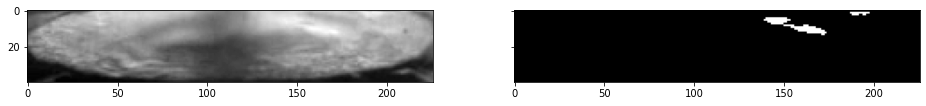

In [ ]:
# Pasta com todos os frames
path = "Data/Output_Data/Frames_Cropped/"

#Nível do Threshold
thresh = 200

# Carregando a imagem
src = cv2.imread(path + frames_list[2780],cv2.IMREAD_GRAYSCALE)
print("Caso " + str(frames_list[2780]))

# Aplicando o Threshold
th, dst = cv2.threshold(src, thresh = thresh, maxval = 255, type = eval('cv2.THRESH_BINARY'))

# Plotando as imagens original e limiarizada
fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(src,'gray')
ax[1].imshow(dst,'gray')

Aplicando a limiarização em todas as imagens

In [ ]:
def limi(thresh):
    
    # Incializando uma lista para guardar as imagens
    im_thresh = []
    Case = []
    q = []
    Area_Not = []
    Area_OK = []

    # Aplicando a limiarização em todas as imagens
    for j,i in enumerate(frames_list):

        # Identificando a evolução do algortimo
        if np.round(j%((len(frames_list)-1)/100),0) == 0:
            print("Foram tratadas " + str(np.round(j/len(frames_list)*100,0)) + "% das imagens para o threshold de " + str(thresh))

        # Carregando a imagem
        src = cv2.imread(path + i,cv2.IMREAD_GRAYSCALE)

        # Aplicando a limiarização 
        th, dst = cv2.threshold(src, thresh = thresh, maxval = 255, type = eval('cv2.THRESH_BINARY'))

        # Adicionando o resultado para a lista 
        im_thresh.append((dst == 255).sum()/np.size(dst)*100)
        Case.append(i[1:3].replace('_', ''))
        q.append(i[3:6].replace('_', ''))
        if i[3:6].replace('_', '') == '225':
            Area_Not.append((dst == 255).sum()/np.size(dst)*100)
        else:
            Area_OK.append((dst == 255).sum()/np.size(dst)*100)

    itv = np.linspace(0,101,50000)

    FP = []
    FN = []

    for i in itv:
        FP.append((Area_OK > i).sum()/len(Area_OK))
        FN.append((Area_Not < i).sum()/len(Area_Not))
    
    return im_thresh, FP, FN, q, itv


In [ ]:
# Array com os thresholds a ser avaliados 
threshes = np.array([180, 200, 220, 240])

In [ ]:
# Listas vazias
FP = []
FN = []

# Cálculo dos Falsos Positivos e Falsos Negativos
for i in threshes:
    im_thresh_t, FP_t, FN_t, q, itv = limi(i)
    FP.append(FP_t)
    FN.append(FN_t)

Foram tratadas 0.0% das imagens para o threshold de 180
Foram tratadas 1.0% das imagens para o threshold de 180
Foram tratadas 3.0% das imagens para o threshold de 180
Foram tratadas 5.0% das imagens para o threshold de 180
Foram tratadas 6.0% das imagens para o threshold de 180
Foram tratadas 8.0% das imagens para o threshold de 180
Foram tratadas 10.0% das imagens para o threshold de 180
Foram tratadas 11.0% das imagens para o threshold de 180
Foram tratadas 13.0% das imagens para o threshold de 180
Foram tratadas 15.0% das imagens para o threshold de 180
Foram tratadas 16.0% das imagens para o threshold de 180
Foram tratadas 18.0% das imagens para o threshold de 180
Foram tratadas 20.0% das imagens para o threshold de 180
Foram tratadas 21.0% das imagens para o threshold de 180
Foram tratadas 23.0% das imagens para o threshold de 180
Foram tratadas 25.0% das imagens para o threshold de 180
Foram tratadas 26.0% das imagens para o threshold de 180
Foram tratadas 28.0% das imagens para

O valor da AUC para um threshold de 180 é de 0.9345324743250707
O valor da AUC para um threshold de 200 é de 0.9923501908816728
O valor da AUC para um threshold de 220 é de 0.9939172047688646
O valor da AUC para um threshold de 240 é de 0.9898974469270739


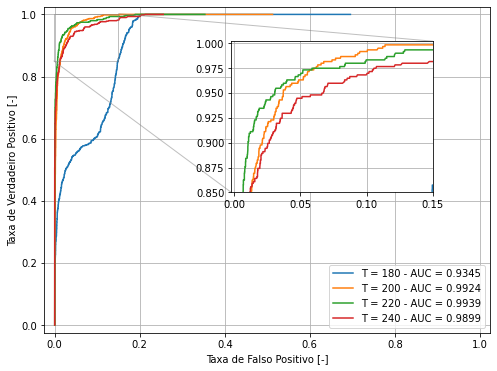

In [ ]:
# plot da ROC e cálculo da AUC-ROC
fig, ax = plt.subplots(figsize = (8,6))

# Lista vazia
AUC = []

for i in range(len(FP)):
    # Cálculo da AUC-ROC
    AUC_i = np.sum((np.array(FN[i][1:]) - np.array(FN[i][:-1]))*((1-np.array(FP[i][1:]))/2 + (1-np.array(FP[i][:-1]))/2))
    AUC.append(AUC_i)
    print("O valor da AUC para um threshold de " +str(threshes[i]) + " é de " + str(AUC_i)) 
    
    # Plot da ROC
    plt.plot(FP[i],1 - np.array(FN[i]), label = 'T = ' + str(threshes[i]) + ' - AUC = ' + str(np.round(AUC_i,4)))



plt.xlim([-0.025,1.025])
plt.ylim([-0.025,1.025])

plt.grid()
plt.legend()

plt.ylabel('Taxa de Verdadeiro Positivo [-]')
plt.xlabel('Taxa de Falso Positivo [-]')

ax_new = fig.add_axes([0.45, 0.45, 0.35, 0.35])
for i in range(len(FP)):
    ax_new.plot(FP[i],1 - np.array(FN[i]))

ax_new.set_xlim([-0.002, 0.15])
ax_new.set_ylim([0.85, 1.002])
ax.indicate_inset_zoom(ax_new)

ax_new.grid()
plt.savefig("Plots/Threshold/ROC.pdf", format="pdf", bbox_inches = "tight")

In [ ]:
# Definição do Threshold com a máxima AUC
#thresh = threshes[np.array(AUC).argmax()]
thresh = 220

In [ ]:
# Cálculo do valor atualizado
im_thresh, FP, FN, q,itv = limi(thresh)

Foram tratadas 0.0% das imagens para o threshold de 220
Foram tratadas 1.0% das imagens para o threshold de 220
Foram tratadas 3.0% das imagens para o threshold de 220
Foram tratadas 5.0% das imagens para o threshold de 220
Foram tratadas 6.0% das imagens para o threshold de 220
Foram tratadas 8.0% das imagens para o threshold de 220
Foram tratadas 10.0% das imagens para o threshold de 220
Foram tratadas 11.0% das imagens para o threshold de 220
Foram tratadas 13.0% das imagens para o threshold de 220
Foram tratadas 15.0% das imagens para o threshold de 220
Foram tratadas 16.0% das imagens para o threshold de 220
Foram tratadas 18.0% das imagens para o threshold de 220
Foram tratadas 20.0% das imagens para o threshold de 220
Foram tratadas 21.0% das imagens para o threshold de 220
Foram tratadas 23.0% das imagens para o threshold de 220
Foram tratadas 25.0% das imagens para o threshold de 220
Foram tratadas 26.0% das imagens para o threshold de 220
Foram tratadas 28.0% das imagens para

In [ ]:
data={'Q': q,'TH':im_thresh}
df=pd.DataFrame(data)

In [ ]:
q = df['Q'].value_counts().index

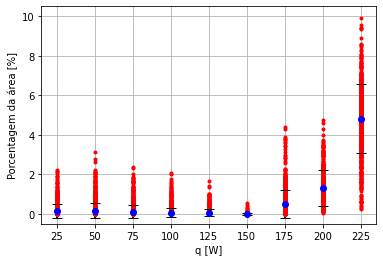

In [ ]:
# Lista para gravar as médias e desvios padrão
mean = []
std = []

# Cálculo das médias, desvios padrão e plotagem
for i in range(9):
    mean.append(df[df['Q'] == str(q[i])]['TH'].mean())
    std.append(df[df['Q'] == str(q[i])]['TH'].std())
    
    # Plotagem completa dos resultados 
    plt.plot(float(q[i])*np.ones(len(df[df['Q'] == str(q[i])]['TH'])), df[df['Q'] == str(q[i])]['TH'],'r.')
plt.grid()
plt.xlabel('q [W]')
plt.ylim([-0.5,10.5])
plt.ylabel('Porcentagem da área [%]')
plt.errorbar(np.float_(q[:9]),mean, std, color='blue', marker='o', linestyle='')
plt.errorbar(np.float_(q[:9]),mean, std, color='black', linestyle='',capsize=5)
plt.savefig('Plots/Threshold/Threshold_full.pdf', format = 'pdf',bbox_inches='tight')

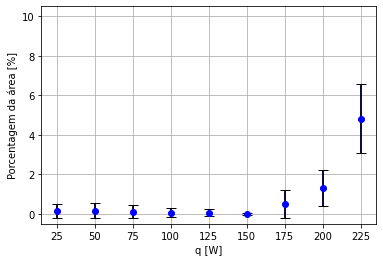

In [ ]:
# Plotagem apenas das médias e desvios padrão
plt.grid()
plt.xlabel('q [W]')
plt.ylabel('Porcentagem da área [%]')
plt.ylim([-0.5,10.5])
plt.errorbar(np.float_(q[:9]),mean, std, color='blue', marker='o', linestyle='')
plt.errorbar(np.float_(q[:9]),mean, std, color='black', linestyle='',capsize=5)
plt.savefig('Plots/Threshold/Threshold.pdf', format = 'pdf', bbox_inches='tight')

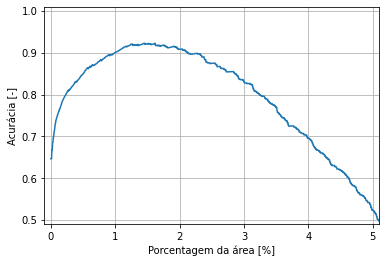

In [ ]:
plt.plot(itv, 1 - (np.array(FP) + np.array(FN)))
plt.xlim([-0.1,5.1])
plt.ylim([0.49,1.01])
plt.grid()
plt.ylabel('Acurácia [-]')
plt.xlabel('Porcentagem da área [%]')
plt.savefig('Plots/Threshold/Acurácia.pdf', format = 'pdf', bbox_inches='tight')

In [ ]:
index = np.array(1 - (np.array(FP) + np.array(FN))).argmax()

print("A Acurácia do modelo no conjunto de treino é de " + str(np.round(np.array(1 - (np.array(FP) + np.array(FN)))[index], 4)) + " para um threshold de " + str(np.round(itv[index] ,3)))

A Acurácia do modelo no conjunto de treino é de 0.9232 para um threshold de 1.452


In [ ]:
# Pasta com os frames do conjunto de traino
path_test = "Data/Output_Data/Sets/validation"

# Carrendo a lista com todas as imagens 
frames_list_crit = os.listdir(path_test + '/Crit')
frames_list_ok = os.listdir(path_test + '/Ok')
frames_list = frames_list_crit + frames_list_ok

In [ ]:
# Cálculo do valor atualizado
im_thresh, FP, FN, q,itv = limi(thresh)

Foram tratadas 0.0% das imagens para o threshold de 220
Foram tratadas 1.0% das imagens para o threshold de 220
Foram tratadas 3.0% das imagens para o threshold de 220
Foram tratadas 4.0% das imagens para o threshold de 220
Foram tratadas 6.0% das imagens para o threshold de 220
Foram tratadas 9.0% das imagens para o threshold de 220
Foram tratadas 11.0% das imagens para o threshold de 220
Foram tratadas 12.0% das imagens para o threshold de 220
Foram tratadas 14.0% das imagens para o threshold de 220


KeyboardInterrupt: ignored

In [ ]:
print("A Acurácia do modelo no conjunto de teste é de " + str(np.round(np.array(1 - (np.array(FP) + np.array(FN)))[index], 4)) + " para um threshold de " + str(np.round(itv[index] ,3)))

A Acurácia do modelo no conjunto de teste é de 0.8304 para um threshold de 1.452


# Aprendizado Profundo

In [ ]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory(training_dir + '/',
                                          target_size=(150,150),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
validation_dataset = test.flow_from_directory(validation_dir + '/',
                                        target_size=(150,150),
                                        batch_size =32,
                                        class_mode = 'binary')

Found 7461 images belonging to 2 classes.
Found 1864 images belonging to 2 classes.


In [ ]:
validation_dataset.class_indices

{'Crit': 0, 'Ok': 1}

In [ ]:
model = keras.Sequential()

model.add(tf.keras.layers.RandomRotation(0.4))

# Camada Convolucional e de Pooling 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal',input_shape=(150,150,3)))
model.add(Dropout(0.4))
model.add(keras.layers.MaxPool2D(2,2))

# Camada Convolucional e de Pooling 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.4))
model.add(keras.layers.MaxPool2D(2,2))

# Camada Convolucional e de Pooling 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(Dropout(0.4))
model.add(keras.layers.MaxPool2D(2,2))

# Camada Convolucional e de Pooling 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(Dropout(0.4))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Flatten())

# Camada totalmente conectada 1
model.add(keras.layers.Dense(10,activation='relu'))
model.add(Dropout(0.2))

# Camada de saída
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
#steps_per_epoch = train_imagesize/batch_size

history = model.fit(train_dataset,
         steps_per_epoch = 200,
         epochs = 20,
         validation_data = validation_dataset,
         validation_steps=50
         )

Epoch 1/20
200/200 [==============================] - 18s 91ms/step - loss: 0.0840 - accuracy: 0.9658 - val_loss: 0.1931 - val_accuracy: 0.9250
Epoch 2/20
200/200 [==============================] - 18s 88ms/step - loss: 0.0838 - accuracy: 0.9638 - val_loss: 0.2265 - val_accuracy: 0.9431
Epoch 3/20
200/200 [==============================] - 18s 88ms/step - loss: 0.0835 - accuracy: 0.9647 - val_loss: 0.1851 - val_accuracy: 0.9219
Epoch 4/20
200/200 [==============================] - 18s 89ms/step - loss: 0.0921 - accuracy: 0.9605 - val_loss: 0.1570 - val_accuracy: 0.9206
Epoch 5/20
200/200 [==============================] - 18s 88ms/step - loss: 0.0902 - accuracy: 0.9601 - val_loss: 0.2880 - val_accuracy: 0.9219
Epoch 6/20
200/200 [==============================] - 18s 90ms/step - loss: 0.0704 - accuracy: 0.9705 - val_loss: 0.1775 - val_accuracy: 0.9231
Epoch 7/20
200/200 [==============================] - 18s 89ms/step - loss: 0.0808 - accuracy: 0.9677 - val_loss: 0.1773 - val_accuracy:

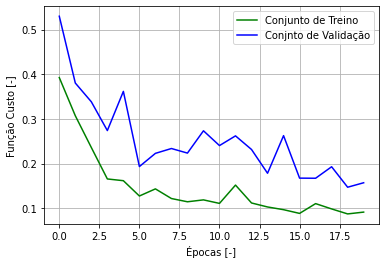

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,20)
plt.plot(epochs, loss_train, 'g', label='Conjunto de Treino')
plt.plot(epochs, loss_val, 'b', label='Conjnto de Validação')
plt.xlabel('Épocas [-]')
plt.ylabel('Função Custo [-]')
plt.grid()
plt.legend()

#plt.savefig('Plots/Deep/Custo.pdf', format = 'pdf', bbox_inches='tight')

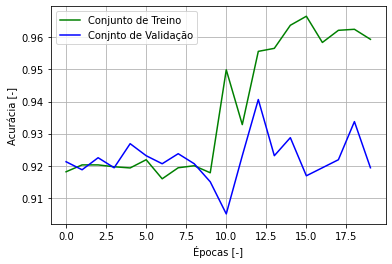

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(0,20)
plt.plot(epochs, acc_train, 'g', label='Conjunto de Treino')
plt.plot(epochs, acc_val, 'b', label='Conjnto de Validação')
plt.xlabel('Épocas [-]')
plt.ylabel('Acurácia [-]')
plt.grid()
plt.legend()

#plt.savefig('Plots/Deep/Acc.pdf', format = 'pdf', bbox_inches='tight')